In [1]:
import os

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *


In [2]:
df_diamonds = pd.read_csv(r'data\processed\diamonds_training.csv', index_col='id')
df_predict = pd.read_csv(r'data\processed\diamonds_testing.csv', index_col='id')


# Consideraciones iniciales

- Los pasos de la parte previa se detallan de forma pormenorizada, paso a paso, en el "notebook" titulado "EDA"

- A grandes rasgos, en ese "notebook" se hacen dos cosas:
1) Modificaciones esenciales (limpieza); se comprueba que no hay duplicados, se cambia el nombre de las columnas y se pasan las categóricas a numéricas, tanto del "train" como del "test".

2) Modificaciones opcionales (para feature engineering); se detectan y ponen a prueba las posibles modifiaciones que llevar a cabo con el "dataframe" de entrenamiento con tal de mejorar el resultado de los modelos. Los resortes de dichos cambios se guardan en forma de funciones (cuando son exclusivos de este proyecto) o clases (cuando es razonable guardarlos para análisis futuros), que se irán llamando a continuación según convenga.

- A partir de lo obtenido en ese primer "notebook" de "EDA", se trabaja en este segundo de "Feature_engineering". Lo que salga de este, se utilizará en el "notebook" llamado "Model_optimization"

# Modelaje

- Esta sección se divide en:

1) Selección de cambios; donde se aplican consecutivamente los cambios opcionales detectados en el EDA ("feature engineering") a todos los modelos para ver cuáles mejoran con qué criterios.

2) Selección de modelos; donde se toman los mejores cambios del punto 1 para cada modelo, se les aplican y se procura mejorarlos aún más con algunos hiperparámetros. Finalmente, por primera vez se comprueba la predicción con "y_test". Se busca obtener a) el mejor modelo para optimizar, y b) información adicional sobre el "dataset".

## Selección de cambios
- Se importan los "dataframes" con las modificaciones esenciales

- Se van intercalando modificaciones opcionales y diversos modelos hasta dar con la mejor combinación para cada modelo

- Inicialmente, todos los modelos se prueban en este "notebook" para mayor comodidad, pero el mejor se trabajará en "Model_optimization" y se ejecutará en "train.py", desde donde se guardará en la carpeta "model"

- Estas son las modificaciones que se van intercalando:

---------- Cambios opcionales (probados) ---------- 

1) Borrado de "outliers" extremadamente altos ("depth (percentage)", "table (percentage)", "width (millimeters)", "depth (millimeters)").

2) Borrado de filas que tienen 0 en todas las variables de tamaño ("lenght (millimeters)", "width (millimeters)" y "depth (millimeters)").

3) Borrado de los "outliers" compartidos moderadamente altos ("depth (percentage)" y "table (percentage)").

4) Asignación del valor con 0 restante en "lenght" al "width" correspondiente ("lenght (millimeters)").

5) Asignación del valor con 0 restante de "depth (millimeters)" a partir de una operación con el "lenght", el "width" y el "depth (percentage)" correspondientes ("depth (millimeters)").

6) Asignación del "outlier" restante del "lenght" al "width" correspondiente ("lenght (millimeters)").

7) Uso del logaritmo ("weight (carat)", "lenght (millimeters)", "width (millimeters)" y "depth (millimeters)").

8) Imputación al siguiente valor más alto ("weight (carat)").

9) Imputación a los valores máximos y mínimos del "boxplot" ("depth (percentage)" y "table (percentage)").

10) Neutralización de "outliers" con un modelo "ridge" ("depth (millimeters)").

11) Escalado.

---------- Cambios apuntados (no probados) ----------

1) Sustitución de valores existentes por valores calculados ("depth (percentage)").

2) Descarte de las columnas con altísima correlación ("weight (carat)", "lenght (millimeters)", "width (millimeters)" y "depth (millimeters)").

3) Imputación de los valores máximos de "clarity quality" al que está un punto por debajo ("clarity quality").


### Ronda 1: sin cambios
- Para la primera fase, se prueban todos los modelos sin hacer ninguna modificación adicional

- En esta primera ronda están más detallados los usos de la clase "Regression", que hereda de "Model", para que sirva como ejemplo

- Como era de esperar, los resultados no son demasiado buenos, pero ganan los modelos "de árboles" ("DecisionTree", "RandomForest" y "XGB")

- Dado que en la competición se valora la "rsme", esa es la métrica que más se tendrá en cuenta. Puede verse el podio aquí: https://www.kaggle.com/competitions/diamonds-part-datamad0122/leaderboard

In [3]:
# Se echa un vistazo a la documentación de la clase "Regression"
print(Regression.__doc__)



    Child class of Model for regression algorithms. To be used directly instead of Model.
    Methods are numbered by recommended order of use.
    Print instance at any time to see the recommended next step

    ...

    Attributes
    -------
    chosen_models : dict
        Empty dict of models to work with (to be filled with empty keys using add_models class method)

    Class methods
    -------
    add_models(*regression)
        1) Adds models to the class attribute chosen_models. Required first, before putting instances to work, since chosen_models is empty by default.
        It should be called only once, except if more models are needed at some point for further analysis

    remove_models(*regression)
        Removes models from the class attribute chosen_models

    Instance methods
    -------
    apply_and_evaluate_kfolds(kfolds_num=5)
        4 & 5) Used when models are prepared (3). Applies the models to the splits of the dataframe using kfolds and gets the metrics. 


In [4]:
# Lo primero es decirle a la clase con qué modelos se va a trabajar a lo largo de todo el proceso
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'SVR',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [5]:
# Se comprueban los parámetros que requiere el constructor
print(Regression.__init__.__doc__)




        Parameters
        ----------
        dataframe : dataframe
            The dataframe to which the models will be used
        target_name : str
            The name of the target column
        index : str (defaut=None)
            The name of the column to become index, if any
        


In [6]:
# Se crea la instancia de la clase "Regression" con la columna "price" como "target"
# En cualquier momento, se puede hacer un "print" de la instancia para obtener una recomendación del siguiente paso
round_1 = Regression(df_diamonds, 'price')

print(round_1)


Regression. Progress: if you have not already, add some models to the class with Regression.add_models(). Then, use split_dataframe() with your instance


In [7]:
# Se comprueban los parámetros de split_dataframe()
print(Regression.split_dataframe.__doc__)


Splits dataframe into X_train, X_test, y_train and y_test.  
Preferably used after adding models to the chosen_models attribute with add_models()

        Parameters
        ----------
        train_num : float (default=0.7)
            Proportion of the train splits
        random_num : int (default=43)
            random_state for the split
        scaler : str (default=None)
            The name of the chosen scaler, if any
        return_entire_Xy: boolean (default=False)
            Changes return to take in the entire X and y insted of its splits

        Returns
        -------
        tuple of pandas objects
            X_train, X_test, y_train and y_test
        


In [8]:
# Se separa el "dataframe" con los parámetros por defecto. Se guardan las porciones por si acaso
X_train, X_test, y_train, y_test = round_1.split_dataframe()

X_train


weight (carat)  cut quality  color quality  clarity quality  \
id                                                                   
26690            1.38          1.0            0.0              1.0   
15750            0.70          4.0            4.0              2.0   
37107            1.51          4.0            0.0              5.0   
34550            0.23          2.0            4.0              7.0   
31691            1.50          3.0            3.0              2.0   
...               ...          ...            ...              ...   
5307             1.56          2.0            4.0              2.0   
25233            1.53          4.0            2.0              2.0   
18448            0.52          2.0            4.0              2.0   
19776            1.20          1.0            3.0              3.0   
14148            1.73          3.0            2.0              3.0   

       depth (percentage)  table (percentage)  lenght (millimeters)  \
id                                                                    
26690                63.7                58.0                  7.06   
15750                61.6                55.0                  5.72   
37107                61.4                59.0                  7.34   
34550                61.0                62.0                  3.95   
31691                60.2                61.0                  7.28   
...                   ...                 ...                   ...   
5307                 61.0                58.0                  7.41   
25233                59.8                59.0                  7.48   
18448                62.3                55.0                  5.14   
19776                57.8                59.0                  7.06   
14148                59.2                61.0                  7.82   

       width (millimeters)  depth (millimeters)  
id                                               
26690                 7.01                 4.48  
15750                 5.74                 3.53  
37107                 7.39                 4.52  
34550                 3.99                 2.42  
31691                 7.20                 4.36  
...                    ...                  ...  
5307                  7.48                 4.54  
25233                 7.54                 4.49  
18448                 5.17                 3.21  
19776                 7.00                 4.06  
14148                 7.78                 4.62  

[28318 rows x 9 columns]

In [9]:
print(round_1)


Regression. Progress: the dataframe has been split. Now, you may prepare your models with the prepare_models() method


In [10]:
# Se comprueban los parámetros de prepare_models()
print(Regression.prepare_models.__doc__)


Makes models suitable for application. Used after the split

        Parameters
        ----------
        selected_list : list of str (default=None)
            Limits the models to be prepared to the ones in this list, if any
        excluded_list : list of str (default=None)
            Excludes the models of the list from the preparation, if any
        params_list : list of lists (default=None)
            For every model (first element of each inner list), applies the chosen hiperparameters 
            (second element of each inner list, all together in a string), if any

        Returns
        -------
        str
            Confirmation
        


In [11]:
# Se establece un "random_state" para los modelos que lo requieren (los "de árboles"), que siempre será el mismo
round_1.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )


'Done'

In [12]:
print(round_1)


Regression. Progress: your models are now prepared. Apply them with apply_models() or use apply_and_evaluate_kfolds() instead if you want kfolds to be used


In [13]:
# Se comprueban los parámetros de apply_and_evaluate_kfolds()
print(Regression.apply_and_evaluate_kfolds.__doc__)


Applies models to the dataframe splits using kfolds and evaluates the subsequent metrics.
Can use apply_models() + evaluate_metrics() instead if kfolds are not wanted

        Parameters
        ----------
        kfolds_num : int (default=5)
            Number of folds

        Returns
        -------
        dict
            Dictionary including models and metrics
        


In [14]:
# Se solicitan 5 "folds" (número por defecto), del cual se usará el mejor para entrenar los modelos y ver cuál llega más lejos
# Como la "target" es de regresión y esa es la clase que se ha instanciado, se seleccionará automáticamente "KFold" en lugar de "StratifiedKFold"
round_1_dict = round_1.apply_and_evaluate_kfolds()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.16 sec(s). Total time: 0.16
Starting Ridge:
- Ridge done in 0.1 sec(s). Total time: 0.26
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 3.7 sec(s). Total time: 3.96
Starting SVR:
- SVR done in 163.65 sec(s). Total time: 167.61
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.79 sec(s). Total time: 169.4
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 103.39 sec(s). Total time: 272.79
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 4.97 sec(s). Total time: 277.76


In [15]:
# La media y la varianza de las métricas, así como el total de cada "fold" entrenado y el modelo en sí, pueden extraerse en un diccionario
round_1_dict


{'LinearRegression': {'models': [LinearRegression(),
   LinearRegression(),
   LinearRegression(),
   LinearRegression(),
   LinearRegression()],
  'metrics': {'rmse': 0.18266434126360717,
   'mse': 0.033668866217605245,
   'mae': 0.11847602510487627,
   'r2_score': 0.9671883402028569,
   'mape': 0.015316754357796062},
  'all_metrics': {'rmse': [0.18278436404836218,
    0.16134131610876856,
    0.21213340614001955,
    0.1873559277102721,
    0.16970669231061353],
   'mse': [0.0334101237405642,
    0.026031020283709582,
    0.04500058200056649,
    0.035102243648176705,
    0.02880036141500925],
   'mae': [0.1198527764880509,
    0.12009375582158771,
    0.11814603052977636,
    0.1176840754805362,
    0.1166034872044301],
   'r2_score': [0.9675277226414865,
    0.9749723070956142,
    0.9554574304863221,
    0.9657327540523,
    0.9722514867385628],
   'mape': [0.015509386119075434,
    0.015492198456540348,
    0.015267110508885734,
    0.015208411444627408,
    0.015106665259851387]

In [16]:
print(round_1)


Regression. Progress: your folds have been applied and the metrics evaluated. Put the results into a dataframe with create_dataframe()


In [17]:
# Se comprueban los parámetros de create_dataframe()
print(Regression.create_dataframe.__doc__)


Creates a dataframe with the metrics of each model.
Used after evaluate_metrics() or apply_and_evaluate_kfolds()

        Parameters
        ----------
        chosen_format : str (default='mean')
            Selected metric format to appear in the resulting dataframe

        Returns
        -------
        dataframe
            Dataframe with models, metrics and BEST/WORST columns
        


In [25]:
# Se ponen esas medias en un "dataframe"
# Las predicciones no son muy buenas, si bien el r2_score es alto para todos los casos
round_1.create_dataframe()


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182664  0.182826             0.181632  0.189328   
mse               0.033669  0.033718             0.033003  0.036192   
mae               0.118476  0.118554             0.135741  0.126174   
r2_score          0.967188  0.967141             0.967889  0.964745   
mape              0.015317  0.015327             0.017877  0.016342   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.130480   
mse                                     0.017029   
mae                                     0.090791   
r2_score                                0.983436   
mape                                    0.011706   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094246   
mse                                     0.008898   
mae                                     0.066789   
r2_score                                0.991340   
mape                                    0.008636   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090762  XGBRegressor: random_state=43   
mse                            0.008247  XGBRegressor: random_state=43   
mae                            0.065596  XGBRegressor: random_state=43   
r2_score                       0.991976  XGBRegressor: random_state=43   
mape                           0.008468  XGBRegressor: random_state=43   

                        WORST  
rmse                      SVR  
mse                       SVR  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

In [19]:
print(round_1)


Regression. Progress: your dataframe with metrics has been created. You may use visualize() to display it graphically


In [20]:
# Se comprueban los parámetros de visualize()
print(Regression.visualize.__doc__)


Creates a lineplot with the metrics of the models. Has no return but shows a graphic for a jupiter notebook. Used after create_dataframe()

        Parameters
        ----------
        metrics_selection : str (*args)
            Selects the metrics for visualization. If none provided, selects all
        


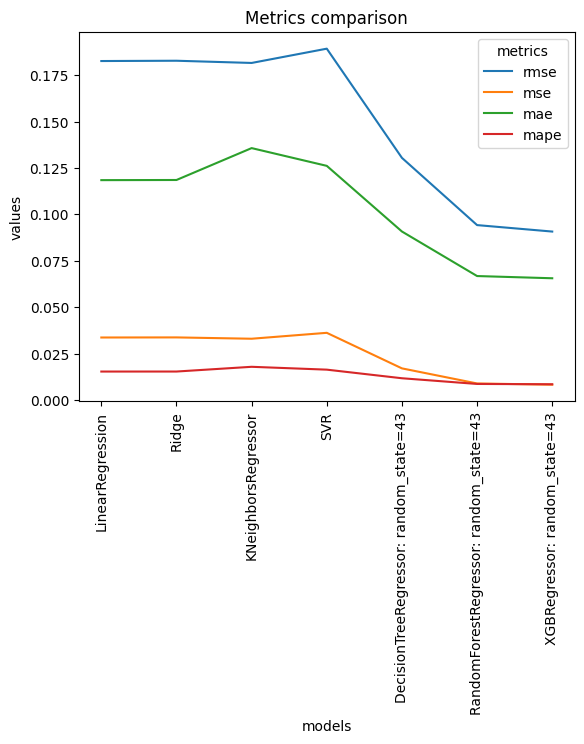

In [27]:
# Se introducen esas medias en una gráfica para comparar mejor los modelos, pero se excluye "r2_score". De entrada, los mejores son los "de árboles"
round_1.visualize('rmse', 'mse', 'mae', 'mape')


In [22]:
print(round_1)


Regression. Progress: you may call create_dataframe() and visualize() multiple times to change how and which metrics are displayed (mean, variance...), or use send_pickle() to save your chosen model


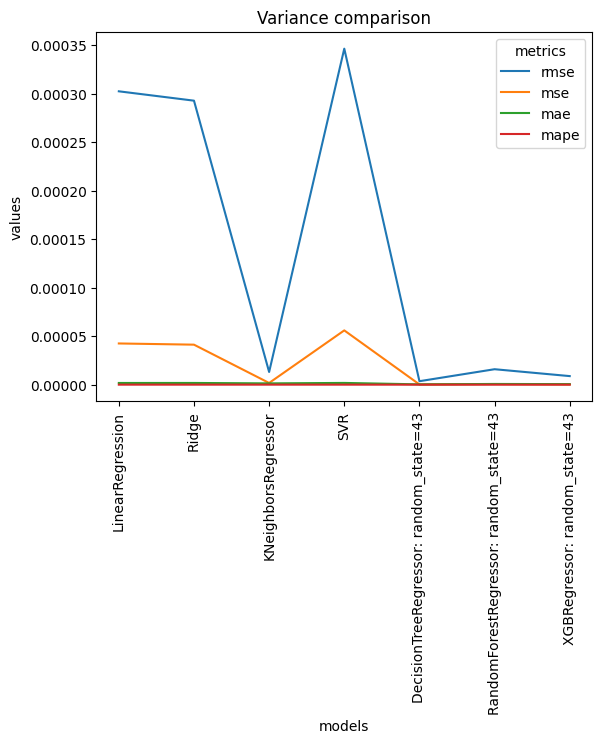

In [23]:
# Se comprueban, también, las varianzas. Son bajas en los modelos "de árboles" y k vecinos, lo cual es un buen indicativo si se acaba eligiendo uno de esos modelos
round_1.create_dataframe(chosen_format='variance')
round_1.visualize('rmse', 'mse', 'mae', 'mape')


### Ronda 2: escalado
- Se repite la ronda 1, pero esta vez se escalan las variables

- Respecto a la ronda 1, exceptuando "Ridge", el escalado "Standard" mejora más que "MinMax" los resultados de los modelos "no de árboles". La regresión lineal no se ve afectada en ningún caso

- Los modelos "de árboles", que son los que tienen "random_state", no necesitan escalado porque no son sensibles a la varianza de los datos

In [ ]:
# Se pone en marcha el mismo proceso que en la ronda anterior, pero esta vez se aplica un escalado MinMax
df_diamonds_2 = df_diamonds.copy()

round_2 = Regression(df_diamonds_2, 'price')
round_2.split_dataframe(scaler='MinMaxScaler')
round_2.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ])
round_2.apply_and_evaluate_kfolds()
round_2.create_dataframe()


-- Regression (MinMaxScaler): using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.13 sec(s). Total time: 0.13
Starting Ridge:
- Ridge done in 0.09 sec(s). Total time: 0.22
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 1.89 sec(s). Total time: 2.11
Starting SVR:
- SVR done in 148.91 sec(s). Total time: 151.02
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.18 sec(s). Total time: 152.2
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 104.86 sec(s). Total time: 257.06
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 4.88 sec(s). Total time: 261.94


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182664  0.181262             0.164514  0.121829   
mse               0.033669  0.033098             0.027074  0.014860   
mae               0.118476  0.124283             0.116946  0.091139   
r2_score          0.967188  0.967752             0.973661  0.985540   
mape              0.015317  0.016057             0.015443  0.012015   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.130760   
mse                                     0.017102   
mae                                     0.090951   
r2_score                                0.983365   
mape                                    0.011723   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094312   
mse                                     0.008910   
mae                                     0.066860   
r2_score                                0.991329   
mape                                    0.008645   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090735  XGBRegressor: random_state=43   
mse                            0.008242  XGBRegressor: random_state=43   
mae                            0.065592  XGBRegressor: random_state=43   
r2_score                       0.991981  XGBRegressor: random_state=43   
mape                           0.008468  XGBRegressor: random_state=43   

                                           WORST  
rmse                            LinearRegression  
mse                             LinearRegression  
mae                                        Ridge  
r2_score  DecisionTreeRegressor: random_state=43  
mape                                       Ridge

In [ ]:
# Se comprueba si la situación mejora con "StandardScaler"
df_diamonds_2b = df_diamonds.copy()

round_2b = Regression(df_diamonds_2b, 'price')
round_2b.split_dataframe(scaler='StandardScaler')
round_2b.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_2b.apply_and_evaluate_kfolds()
round_2b.create_dataframe()


-- Regression (StandardScaler): using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.13 sec(s). Total time: 0.13
Starting Ridge:
- Ridge done in 0.08 sec(s). Total time: 0.21
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 2.86 sec(s). Total time: 3.07
Starting SVR:
- SVR done in 129.12 sec(s). Total time: 132.19
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.35 sec(s). Total time: 133.54
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 129.78 sec(s). Total time: 263.32
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 13.21 sec(s). Total time: 276.53


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182664  0.182891             0.144004  0.107316   
mse               0.033669  0.033741             0.020743  0.011518   
mae               0.118476  0.118530             0.106323  0.081209   
r2_score          0.967188  0.967119             0.979820  0.988797   
mape              0.015317  0.015324             0.014035  0.010658   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.130423   
mse                                     0.017014   
mae                                     0.090689   
r2_score                                0.983450   
mape                                    0.011692   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094255   
mse                                     0.008900   
mae                                     0.066785   
r2_score                                0.991339   
mape                                    0.008636   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090741  XGBRegressor: random_state=43   
mse                            0.008243  XGBRegressor: random_state=43   
mae                            0.065580  XGBRegressor: random_state=43   
r2_score                       0.991980  XGBRegressor: random_state=43   
mape                           0.008466  XGBRegressor: random_state=43   

                                           WORST  
rmse                                       Ridge  
mse                                        Ridge  
mae                                        Ridge  
r2_score  DecisionTreeRegressor: random_state=43  
mape                                       Ridge

### Ronda 3: borrado
- Se borran todos los "outliers" extremadamente altos ("depth (percentage)", "table (percentage)", "width (millimeters)", "depth (millimeters)")

- Se borran las filas que tienen el mismo cero en estas tres columnas: "lenght (millimeters)", "width (millimeters)" y "depth (millimeters)"

- Se borran los "outliers" moderadamente altos compartidos de "depth (percentage)" y "table (percentage)"

- Respecto a la ronda 1, el error mejora en todos los modelos menos "XGBR" y "DecisionTree"

In [ ]:
# Se aplican los borrados; esta vez, con una función a medida, ya que son cambios exclusivos de este proyecto
# Las funciones a medida de este proyecto se encuentran en "functions.py" de la carpeta "utils"
df_diamonds_3 = df_diamonds.copy()

df_diamonds_3 = remove_all(df_diamonds_3)

print(f'Deleted rows: {len(df_diamonds) - len(df_diamonds_3)}')


Deleted rows: 20


In [ ]:
# Se prueban los modelos
round_3 = Regression(df_diamonds_3, 'price')
round_3.split_dataframe()
round_3.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_3.apply_and_evaluate_kfolds()
round_3.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.16 sec(s). Total time: 0.16
Starting Ridge:
- Ridge done in 0.1 sec(s). Total time: 0.25
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 4.16 sec(s). Total time: 4.41
Starting SVR:
- SVR done in 182.14 sec(s). Total time: 186.55
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.34 sec(s). Total time: 187.9
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 131.16 sec(s). Total time: 319.05
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 8.56 sec(s). Total time: 327.61


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.152523  0.152468             0.181292  0.167338   
mse               0.023310  0.023292             0.032870  0.028015   
mae               0.114518  0.114516             0.135927  0.126121   
r2_score          0.977458  0.977475             0.968222  0.972910   
mape              0.014986  0.014985             0.017928  0.016343   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.130832   
mse                                     0.017120   
mae                                     0.089546   
r2_score                                0.983450   
mape                                    0.011541   

          RandomForestRegressor: random_state=43  \
rmse                                    0.093747   
mse                                     0.008793   
mae                                     0.066676   
r2_score                                0.991502   
mape                                    0.008626   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090978  XGBRegressor: random_state=43   
mse                            0.008279  XGBRegressor: random_state=43   
mae                            0.065759  XGBRegressor: random_state=43   
r2_score                       0.991997  XGBRegressor: random_state=43   
mape                           0.008484  XGBRegressor: random_state=43   

                        WORST  
rmse      KNeighborsRegressor  
mse       KNeighborsRegressor  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 4: asignación (+ borrado)

- Para poder hacer la asignación, es necesario el borrado aunque haya dado malos resultados para algunos modelos

- Los cambios de esta ronda se aplican a partir de dos hechos probados durante el EDA: 

1) El "lenght" y el "width" son generalmente casi idénticos, ya que los diamantes son semicirculares.

2) El "depth (percentage)" se obtiene (según el autor del "dataset") de dividir "depth (millimeters)" por la media de "lenght" y "width" (el diámetro).

- Se asigna el 0 restante de "lenght" al "width" correspondiente ("lenght (millimeters)")

- Se asigna el 0 restante de "depth (millimeters)" a partir de la operación mencionada

- Se asigna el "outlier" restante del "lenght" al "width" correspondiente ("lenght (millimeters)")

- Respecto a la ronda 3, mejoran todos los modelos. Para los modelos "de árboles", se apunta que, en la fase de "Selección de modelos", será mejor hacer una asignación parcial que no incluya el imputado de "outliers"

In [ ]:
# Se aplican el borrado y la asignación
df_diamonds_4a = df_diamonds.copy()

df_diamonds_4a = remove_all(df_diamonds_4a)
df_diamonds_4a = assign_values(df_diamonds_4a)


In [ ]:
# Se prueban los modelos
round_4a = Regression(df_diamonds_4a, 'price')
round_4a.split_dataframe()
round_4a.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_4a.apply_and_evaluate_kfolds()
round_4a.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.27 sec(s). Total time: 0.27
Starting Ridge:
- Ridge done in 0.14 sec(s). Total time: 0.41
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 3.86 sec(s). Total time: 4.27
Starting SVR:
- SVR done in 184.19 sec(s). Total time: 188.46
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.21 sec(s). Total time: 189.66
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 124.36 sec(s). Total time: 314.02
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 11.7 sec(s). Total time: 325.72


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.147629  0.147579             0.180480  0.164895   
mse               0.021797  0.021782             0.032576  0.027199   
mae               0.113331  0.113336             0.135717  0.125706   
r2_score          0.978930  0.978944             0.968510  0.973708   
mape              0.014799  0.014799             0.017905  0.016295   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.129729   
mse                                     0.016832   
mae                                     0.088872   
r2_score                                0.983728   
mape                                    0.011452   

          RandomForestRegressor: random_state=43  \
rmse                                    0.093724   
mse                                     0.008789   
mae                                     0.066668   
r2_score                                0.991507   
mape                                    0.008625   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090881  XGBRegressor: random_state=43   
mse                            0.008261  XGBRegressor: random_state=43   
mae                            0.065547  XGBRegressor: random_state=43   
r2_score                       0.992015  XGBRegressor: random_state=43   
mape                           0.008455  XGBRegressor: random_state=43   

                        WORST  
rmse      KNeighborsRegressor  
mse       KNeighborsRegressor  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 5: logaritmo (+ borrado y asignación)

- Incluso para los modelos que han dado peores resultados, la asignación y el borrado son necesarios para neutralizar los ceros antes de aplicar el logaritmo

- Se aplica el logaritmo a las columnas "weight (carat)", "lenght (millimeters)", "width (millimeters)" y "depth (millimeters)"

- Comparados con la ronda 4, mejoran ligeramente la regresión lineal, "ridge" y SVC

In [ ]:
# Se hacen los retoques
df_diamonds_5 = df_diamonds.copy()

df_diamonds_5 = remove_all(df_diamonds_5)
df_diamonds_5 = assign_values(df_diamonds_5)
df_diamonds_5[['weight (carat)', 
               'lenght (millimeters)', 
               'width (millimeters)', 
               'depth (millimeters)']] = np.log(df_diamonds_5[['weight (carat)', 
                                                               'lenght (millimeters)', 
                                                               'width (millimeters)', 
                                                               'depth (millimeters)'
                                                               ]
                                                               ]
                                                )


In [ ]:
# Se prueban los modelos
round_5 = Regression(df_diamonds_5, 'price')
round_5.split_dataframe()
round_5.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_5.apply_and_evaluate_kfolds()
round_5.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.33 sec(s). Total time: 0.33
Starting Ridge:
- Ridge done in 0.2 sec(s). Total time: 0.53
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 5.5 sec(s). Total time: 6.02
Starting SVR:
- SVR done in 345.74 sec(s). Total time: 351.77
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 2.6 sec(s). Total time: 354.36
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 244.96 sec(s). Total time: 599.32
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 14.11 sec(s). Total time: 613.42


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.146282  0.146204             0.352911  0.159452   
mse               0.021401  0.021379             0.124552  0.025428   
mae               0.113335  0.113382             0.259885  0.125998   
r2_score          0.979309  0.979331             0.879584  0.975418   
mape              0.014820  0.014838             0.033432  0.016397   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.129840   
mse                                     0.016861   
mae                                     0.088945   
r2_score                                0.983701   
mape                                    0.011463   

          RandomForestRegressor: random_state=43  \
rmse                                    0.093827   
mse                                     0.008808   
mae                                     0.066729   
r2_score                                0.991488   
mape                                    0.008635   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090882  XGBRegressor: random_state=43   
mse                            0.008261  XGBRegressor: random_state=43   
mae                            0.065549  XGBRegressor: random_state=43   
r2_score                       0.992015  XGBRegressor: random_state=43   
mape                           0.008455  XGBRegressor: random_state=43   

                        WORST  
rmse      KNeighborsRegressor  
mse       KNeighborsRegressor  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 6: valor más alto de "weight"
- Se imputan los valores atípicos al siguiente valor más alto de "weight"

- Comparados con la ronda 1, mejoran todos menos "ridge" y regresión lineal

- Para los modelos "de árboles", se ignora (este, y todos los cambios que supongan alterar "outliers"), ya que no les afectan los valores atípicos

In [ ]:
# Se hacen los retoques pertinentes
df_diamonds_6a = df_diamonds.copy()

df_diamonds_6a = impute_next_higher(df_diamonds_6a, log=False)


In [ ]:
# Se lleva a cabo la prueba
round_6a = Regression(df_diamonds_6a, 'price')
round_6a.split_dataframe()
round_6a.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_6a.apply_and_evaluate_kfolds()
round_6a.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.29 sec(s). Total time: 0.29
Starting Ridge:
- Ridge done in 0.19 sec(s). Total time: 0.47
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 6.32 sec(s). Total time: 6.79
Starting SVR:
- SVR done in 329.11 sec(s). Total time: 335.9
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 2.53 sec(s). Total time: 338.43
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 212.82 sec(s). Total time: 551.25
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 15.09 sec(s). Total time: 566.34


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182788  0.182904             0.181511  0.185459   
mse               0.033544  0.033583             0.032961  0.034844   
mae               0.125334  0.125346             0.135657  0.120709   
r2_score          0.967333  0.967295             0.967930  0.966052   
mape              0.016147  0.016149             0.017870  0.015703   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.130361   
mse                                     0.016999   
mae                                     0.090517   
r2_score                                0.983466   
mape                                    0.011679   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094329   
mse                                     0.008914   
mae                                     0.066856   
r2_score                                0.991324   
mape                                    0.008644   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090458  XGBRegressor: random_state=43   
mse                            0.008189  XGBRegressor: random_state=43   
mae                            0.065434  XGBRegressor: random_state=43   
r2_score                       0.992032  XGBRegressor: random_state=43   
mape                           0.008448  XGBRegressor: random_state=43   

                        WORST  
rmse                      SVR  
mse                       SVR  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 7: imputaciones "boxplot"
- Se imputan los valores atípicos al máximo y al mínimo "depth (percentage)" y "table"

- Comparados con la ronda 1, todos los modelos no "de árboles" mejoran

In [ ]:
df_diamonds_6b = df_diamonds.copy()

df_diamonds_6b = impute_boxplot_min_max(df_diamonds_6b, ['depth (percentage)', 'table (percentage)'])


In [ ]:
# Se lleva a cabo la prueba
round_6b = Regression(df_diamonds_6b, 'price')
round_6b.split_dataframe()
round_6b.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_6b.apply_and_evaluate_kfolds()
round_6b.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.32 sec(s). Total time: 0.32
Starting Ridge:
- Ridge done in 0.19 sec(s). Total time: 0.51
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 6.35 sec(s). Total time: 6.86
Starting SVR:
- SVR done in 330.58 sec(s). Total time: 337.43
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 2.94 sec(s). Total time: 340.37
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 211.85 sec(s). Total time: 552.22
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 15.91 sec(s). Total time: 568.14


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182236  0.182393             0.178449  0.188845   
mse               0.033512  0.033560             0.031860  0.036012   
mae               0.118213  0.118289             0.134078  0.125982   
r2_score          0.967341  0.967295             0.969000  0.964919   
mape              0.015287  0.015296             0.017666  0.016315   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.131017   
mse                                     0.017170   
mae                                     0.090738   
r2_score                                0.983301   
mape                                    0.011701   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094343   
mse                                     0.008916   
mae                                     0.066850   
r2_score                                0.991323   
mape                                    0.008644   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090439  XGBRegressor: random_state=43   
mse                            0.008185  XGBRegressor: random_state=43   
mae                            0.065478  XGBRegressor: random_state=43   
r2_score                       0.992037  XGBRegressor: random_state=43   
mape                           0.008449  XGBRegressor: random_state=43   

                        WORST  
rmse                      SVR  
mse                       SVR  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 8: imputaciones "ridge"
- Se imputan los "outliers" de "depth (millimeters)" aplicando un modelo "Ridge" a "weight (carat)", "lenght (millimeters)" y "width (millimeters)", con las que tiene una altísima correlación

- Comparados con la ronda 1, todos los modelos "no de árboles" mejoran


In [ ]:
# Se hacen los cambios
df_diamonds_7 = df_diamonds.copy()

df_diamonds_7 = apply_ridge(df_diamonds_7)


In [ ]:
# Se prueban los modelos
round_7 = Regression(df_diamonds_7, 'price')
round_7.split_dataframe()
round_7.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_7.apply_and_evaluate_kfolds()
round_7.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.34 sec(s). Total time: 0.34
Starting Ridge:
- Ridge done in 0.11 sec(s). Total time: 0.45
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 9.0 sec(s). Total time: 9.46
Starting SVR:
- SVR done in 353.22 sec(s). Total time: 362.67
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 3.45 sec(s). Total time: 366.13
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 227.77 sec(s). Total time: 593.89
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 21.44 sec(s). Total time: 615.33


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.176916  0.176822             0.181088  0.185743   
mse               0.031536  0.031506             0.032807  0.034888   
mae               0.116214  0.116236             0.135562  0.125821   
r2_score          0.969274  0.969303             0.968079  0.966007   
mape              0.015108  0.015107             0.017857  0.016300   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.131214   
mse                                     0.017223   
mae                                     0.090723   
r2_score                                0.983247   
mape                                    0.011698   

          RandomForestRegressor: random_state=43  \
rmse                                    0.094303   
mse                                     0.008909   
mae                                     0.066834   
r2_score                                0.991329   
mape                                    0.008642   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090404  XGBRegressor: random_state=43   
mse                            0.008181  XGBRegressor: random_state=43   
mae                            0.065434  XGBRegressor: random_state=43   
r2_score                       0.992040  XGBRegressor: random_state=43   
mape                           0.008450  XGBRegressor: random_state=43   

                        WORST  
rmse                      SVR  
mse                       SVR  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

### Ronda 9: sustitución (+ borrado parcial y asignación)
- Se sustituyen los valores de "depth (percentage)" por los resultados reales que da el cálculo a partir de las columnas correspondientes

- Como se ha visto en EDA, el resultado serán muchos nuevos "outliers". Por tanto, se aplicará el cambio en el "dataframe" original sin otras modificaciones para comprobar si supone una mejora

- La única modificación adicional indispensable es el tratamiento de los 0 en esas columnas

- Para comprobar si realmente hay mejora, se aplican los modelos dos veces: una solo con las modificaciones de borrado parcial y asignación, y otra con la sustitución

- Comparados exclusivamente con el tratamiento previo (esta misma ronda), con la sustitución mejoran todos menos "DecisionTree" y "XGB"

- Comparados con la ronda 3, k vecinos y los "de árboles" mejoran más con el borrado parcial que con el total. "DecisionTree" y "XGB", que empeoraban con el borrado total, mejoran con este


In [ ]:
# Se aplican los cambios
df_diamonds_8a = df_diamonds.copy()

df_diamonds_8a = remove_all(df_diamonds_8a, zeros_only=True)


In [ ]:
# Se pone a prueba solo el borrado parcial
round_8a = Regression(df_diamonds_8a, 'price')
round_8a.split_dataframe()
round_8a.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_8a.apply_and_evaluate_kfolds()
round_8a.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.19 sec(s). Total time: 0.19
Starting Ridge:
- Ridge done in 0.13 sec(s). Total time: 0.32
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 4.14 sec(s). Total time: 4.46
Starting SVR:
- SVR done in 180.37 sec(s). Total time: 184.83
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.96 sec(s). Total time: 186.79
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 122.43 sec(s). Total time: 309.22
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 8.82 sec(s). Total time: 318.04


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.266568  0.266062             0.180426  0.181529   
mse               0.114192  0.113399             0.032561  0.033473   
mae               0.118374  0.118385             0.135923  0.126591   
r2_score          0.887420  0.888206             0.968440  0.967462   
mape              0.015329  0.015330             0.017890  0.016404   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.129324   
mse                                     0.016732   
mae                                     0.089688   
r2_score                                0.983779   
mape                                    0.011553   

          RandomForestRegressor: random_state=43  \
rmse                                    0.093702   
mse                                     0.008783   
mae                                     0.066922   
r2_score                                0.991487   
mape                                    0.008656   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.090666  XGBRegressor: random_state=43   
mse                            0.008222  XGBRegressor: random_state=43   
mae                            0.065817  XGBRegressor: random_state=43   
r2_score                       0.992032  XGBRegressor: random_state=43   
mape                           0.008498  XGBRegressor: random_state=43   

                        WORST  
rmse         LinearRegression  
mse          LinearRegression  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

In [ ]:
# Se ponen a prueba el borrado parcial con la asignación y la sustitución
df_diamonds_8b = df_diamonds_8a.copy()

df_diamonds_8b = assign_values(df_diamonds_8b)
df_diamonds_8b['depth (percentage)'] = (df_diamonds_8b['depth (millimeters)'] / ((df_diamonds_8b['lenght (millimeters)']+df_diamonds_8b['width (millimeters)']) / 2)) * 100

round_8b = Regression(df_diamonds_8b, 'price')
round_8b.split_dataframe()
round_8b.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_8b.apply_and_evaluate_kfolds()
round_8b.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.17 sec(s). Total time: 0.17
Starting Ridge:
- Ridge done in 0.09 sec(s). Total time: 0.26
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 3.14 sec(s). Total time: 3.4
Starting SVR:
- SVR done in 160.55 sec(s). Total time: 163.95
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.43 sec(s). Total time: 165.38
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 123.86 sec(s). Total time: 289.23
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 6.8 sec(s). Total time: 296.03


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.204595  0.202862             0.179321  0.176235   
mse               0.050146  0.050052             0.032161  0.031325   
mae               0.120780  0.120842             0.135853  0.126536   
r2_score          0.951569  0.951689             0.968831  0.969632   
mape              0.015791  0.015790             0.017885  0.016401   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.129540   
mse                                     0.016786   
mae                                     0.089725   
r2_score                                0.983730   
mape                                    0.011560   

          RandomForestRegressor: random_state=43  \
rmse                                    0.093643   
mse                                     0.008772   
mae                                     0.066871   
r2_score                                0.991498   
mape                                    0.008653   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.091386  XGBRegressor: random_state=43   
mse                            0.008354  XGBRegressor: random_state=43   
mae                            0.066288  XGBRegressor: random_state=43   
r2_score                       0.991903  XGBRegressor: random_state=43   
mape                           0.008558  XGBRegressor: random_state=43   

                        WORST  
rmse         LinearRegression  
mse          LinearRegression  
mae       KNeighborsRegressor  
r2_score     LinearRegression  
mape      KNeighborsRegressor

### Ronda 10: descarte
- Se quitan directamente las columnas con altísima correlación, cercana a 1 ("weight", "lenght", "width" y "depth (millimeters)")

- Se quitan también, a parte, las que tienen una correlación próxima a 0

- Se utiliza el "dataframe" sin cambios ni escalado para el contraste

- Comparados con la ronda 1, con el descarte de alta correlación no mejora ninguno

- Comparados con la ronda 1, con el descarte de correlaciones ínfimas mejoran "SVR" y k vecinos

In [ ]:
# Se hace la prueba
df_diamonds_9a = df_diamonds.copy()

df_diamonds_9a = df_diamonds_9a.drop(columns=['weight (carat)', 'lenght (millimeters)', 'width (millimeters)', 'depth (millimeters)'])

round_9a = Regression(df_diamonds_9a, 'price')
round_9a.split_dataframe()
round_9a.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_9a.apply_and_evaluate_kfolds()
round_9a.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.23 sec(s). Total time: 0.23
Starting Ridge:
- Ridge done in 0.12 sec(s). Total time: 0.36
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 1.81 sec(s). Total time: 2.16
Starting SVR:
- SVR done in 284.91 sec(s). Total time: 287.07
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.62 sec(s). Total time: 287.69
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 49.7 sec(s). Total time: 337.39
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 3.69 sec(s). Total time: 341.08


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.967505  0.967505             1.015364  0.974499   
mse               0.936093  0.936093             1.031027  0.949679   
mae               0.800726  0.800727             0.818281  0.789581   
r2_score          0.089654  0.089654            -0.002618  0.076429   
mape              0.105039  0.105039             0.106717  0.103371   

          DecisionTreeRegressor: random_state=43  \
rmse                                    1.194726   
mse                                     1.427388   
mae                                     0.918272   
r2_score                               -0.388184   
mape                                    0.119392   

          RandomForestRegressor: random_state=43  \
rmse                                    1.017774   
mse                                     1.035893   
mae                                     0.809413   
r2_score                               -0.007383   
mape                                    0.105573   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.947318  XGBRegressor: random_state=43   
mse                            0.897441  XGBRegressor: random_state=43   
mae                            0.775724  XGBRegressor: random_state=43   
r2_score                       0.127223  XGBRegressor: random_state=43   
mape                           0.101540  XGBRegressor: random_state=43   

                                           WORST  
rmse      DecisionTreeRegressor: random_state=43  
mse       DecisionTreeRegressor: random_state=43  
mae       DecisionTreeRegressor: random_state=43  
r2_score  RandomForestRegressor: random_state=43  
mape      DecisionTreeRegressor: random_state=43

In [ ]:
# Para sacar más partido a esta ronda, se comprueba el resultado de eliminar las columnas con una correlación próxima a 0
df_diamonds_9b = df_diamonds.copy()

df_diamonds_9b = df_diamonds_9b.drop(columns=['cut quality', 'depth (percentage)'])

round_9b = Regression(df_diamonds_9b, 'price')
round_9b.split_dataframe()
round_9b.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_9b.apply_and_evaluate_kfolds()
round_9b.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.14 sec(s). Total time: 0.14
Starting Ridge:
- Ridge done in 0.13 sec(s). Total time: 0.27
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 1.58 sec(s). Total time: 1.85
Starting SVR:
- SVR done in 145.99 sec(s). Total time: 147.84
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.0 sec(s). Total time: 148.84
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 84.33 sec(s). Total time: 233.16
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 4.21 sec(s). Total time: 237.37


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.206539  0.206540             0.144592  0.172820   
mse               0.043279  0.043274             0.020913  0.030168   
mae               0.128576  0.128630             0.104260  0.117265   
r2_score          0.957918  0.957924             0.979653  0.970607   
mape              0.016604  0.016611             0.013769  0.015292   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.132375   
mse                                     0.017530   
mae                                     0.091861   
r2_score                                0.982949   
mape                                    0.011848   

          RandomForestRegressor: random_state=43  \
rmse                                    0.095910   
mse                                     0.009216   
mae                                     0.068193   
r2_score                                0.991031   
mape                                    0.008816   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.092922  XGBRegressor: random_state=43   
mse                            0.008640  XGBRegressor: random_state=43   
mae                            0.067016  XGBRegressor: random_state=43   
r2_score                       0.991594  XGBRegressor: random_state=43   
mape                           0.008646  XGBRegressor: random_state=43   

                     WORST  
rmse                 Ridge  
mse       LinearRegression  
mae                  Ridge  
r2_score               SVR  
mape                 Ridge

### Ronda 11: imputaciones "clarity quality"
- Se imputan los valores de 7 "clarity quality" al 6. Esto se hace porque se ha visto en el EDA que las variables relacionadas con el tamaño ('weight (carat)', 'lenght (millimeters)', 'width (millimeters)' y 'depth (millimeters)') dejan de disminuir a partir del 6

- Se utiliza el "dataframe" sin cambios ni escalado para el contraste

- Comparados con la ronda 1, mejoran "ridge", regresión lineal y k vecinos

In [ ]:
# Se comprueba
df_diamonds_10 = df_diamonds.copy()

df_diamonds_10.loc[df_diamonds_10['clarity quality'] == 7, 'clarity quality'] = 6

round_10 = Regression(df_diamonds_10, 'price')
round_10.split_dataframe()
round_10.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
round_10.apply_and_evaluate_kfolds()
round_10.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.17 sec(s). Total time: 0.17
Starting Ridge:
- Ridge done in 0.14 sec(s). Total time: 0.3
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 4.34 sec(s). Total time: 4.64
Starting SVR:
- SVR done in 203.22 sec(s). Total time: 207.87
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.36 sec(s). Total time: 209.23
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 126.28 sec(s). Total time: 335.51
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 7.18 sec(s). Total time: 342.69


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.182263  0.182425             0.181087  0.189843   
mse               0.033524  0.033573             0.032806  0.036387   
mae               0.118175  0.118252             0.135665  0.126377   
r2_score          0.967330  0.967283             0.968081  0.964555   
mape              0.015286  0.015296             0.017872  0.016373   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.131987   
mse                                     0.017425   
mae                                     0.092126   
r2_score                                0.983052   
mape                                    0.011904   

          RandomForestRegressor: random_state=43  \
rmse                                    0.095414   
mse                                     0.009120   
mae                                     0.068013   
r2_score                                0.991125   
mape                                    0.008810   

          XGBRegressor: random_state=43                           BEST  \
rmse                           0.091501  XGBRegressor: random_state=43   
mse                            0.008376  XGBRegressor: random_state=43   
mae                            0.066721  XGBRegressor: random_state=43   
r2_score                       0.991851  XGBRegressor: random_state=43   
mape                           0.008628  XGBRegressor: random_state=43   

                        WORST  
rmse                      SVR  
mse                       SVR  
mae       KNeighborsRegressor  
r2_score                  SVR  
mape      KNeighborsRegressor

## Selección de modelos

- En esta fase, se prueban hiperparámetros para los distintos modelos con sus cambios

- Los hiperparámetros no se investigan de forma exhaustiva; lo que se pretende es reducir la diferencia de aquellos que mejoran mucho con parámetros alternativos para que la selección del modelo a optimizar sea más justa

- Cada uno de los modelos mejora con los siguientes cambios:

---------- LinearRegression (mejor rmse hasta ahora: 0.146282, ronda 5) ----------

· Borrado

· Asignación

· Logaritmo

· Imputaciones "boxplot"

· Imputaciones "ridge"

· Sustitución

· Imputaciones "clarity quality"

---------- Ridge (mejor rmse hasta ahora: 0.146204, ronda 5) ----------

· Escalado "MinMax"

· Borrado

· Asignación

· Logaritmo

· Imputaciones "boxplot"

· Imputaciones "ridge"

· Sustitución

· Imputaciones "clarity quality"

---------- KNeighborsRegressor (mejor rmse hasta ahora: 0.144004, ronda 2) ----------

· Escalado "Standard"

· Borrado parcial

· Asignación

· Valor más alto de "weight"

· Imputaciones "boxplot"

· Imputaciones "ridge"

· Sustitución

· Descarte correlación ínfima

· Imputaciones "clarity quality"

---------- SVR (mejor rmse hasta ahora: 0.107316, ronda 2) ----------

· Escalado "Standard"

· Borrado

· Asignación

· Logaritmo

· Valor más alto de "weight"

· Imputaciones "boxplot"

· Imputaciones "ridge"

· Sustitución

· Descarte correlación ínfima

---------- DecisionTree (mejor rmse hasta ahora: 0.129357, ronda 9) ----------

· Borrado parcial

· Asignación parcial

---------- RandomForest (mejor rmse hasta ahora: 0.093643, ronda 9) ----------

· Borrado parcial

· Asignación parcial

· Sustitución

---------- XGBRegressor (mejor rmse hasta ahora: 0.090404, ronda 8) ----------

· Borrado parcial

· Asignación parcial


### "Ridge" y "LinearRegression"

- Cambios: escalado "MinMax", borrado, asignación, logaritmo, imputaciones "boxplot", imputaciones "ridge", sustitución e imputaciones "clarity quality"

- Como mejoran con los mismos cambios y "LinearRegression" no se ve afectada por los escalados, se prueban juntos

- Con cambios e hiperparámetros, "LinearRegression" aplicado al "y_test" mejora su "rmse" de 0.182664 a 0.143851 (-21.24%)

- Con cambios e hiperparámetros, "Ridge" aplicado al "y_test" mejora su "rmse" de 0.182826 a 0.144234 (-21.11%)

In [ ]:
# Se crean el "scorer" (a partir de una función importada de "functions") y los "kfolds"
rmse = make_scorer(calculate_rmse, greater_is_better=False)
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)


In [ ]:
# Se aplican todos los cambios del listado en común
df_ridge_linear = df_diamonds.copy()

df_ridge_linear = remove_all(df_ridge_linear)
df_ridge_linear = assign_values(df_ridge_linear)
df_ridge_linear[['weight (carat)', 
                    'lenght (millimeters)', 
                    'width (millimeters)', 
                    'depth (millimeters)']] = np.log(df_ridge_linear[['weight (carat)', 
                                                                        'lenght (millimeters)', 
                                                                        'width (millimeters)', 
                                                                        'depth (millimeters)'
                                                                        ]
                                                                    ]
                                                    )
df_ridge_linear = impute_boxplot_min_max(df_ridge_linear, ['depth (percentage)', 'table (percentage)'])
df_ridge_linear = apply_ridge(df_ridge_linear)
df_ridge_linear['depth (percentage)'] = (df_ridge_linear['depth (millimeters)'] / ((df_ridge_linear['lenght (millimeters)']+df_ridge_linear['width (millimeters)']) / 2)) * 100
df_ridge_linear.loc[df_ridge_linear['clarity quality'] == 7.0, 'clarity quality'] = 6.0


In [ ]:
# Se prueban en un "dataframe" conjunto
ridge_linear = Regression(df_ridge_linear, 'price')
X_train, X_test, y_train, y_test = ridge_linear.split_dataframe(scaler='MinMaxScaler')
ridge_linear.prepare_models(selected_list=['LinearRegression', 'Ridge'])
ridge_linear.apply_and_evaluate_kfolds()
ridge_linear.create_dataframe()


-- Regression (MinMaxScaler): using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.16 sec(s). Total time: 0.16
Starting Ridge:
- Ridge done in 0.1 sec(s). Total time: 0.27


LinearRegression     Ridge              BEST  WORST
rmse              0.145544  0.146181  LinearRegression  Ridge
mse               0.021186  0.021372  LinearRegression  Ridge
mae               0.112806  0.113685  LinearRegression  Ridge
r2_score          0.979516  0.979337  LinearRegression  Ridge
mape              0.014745  0.014883  LinearRegression  Ridge

In [ ]:
# Se busca la mejor media de 5 "folds" para la regresión lineal modificando los hiperparámetros
model = LinearRegression()

params = {'fit_intercept': [True, False],
            'positive': [True, False],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END fit_intercept=True, positive=True;, score=-0.148 total time=   0.0s
[CV 2/5] END fit_intercept=True, positive=True;, score=-0.146 total time=   0.0s
[CV 3/5] END fit_intercept=True, positive=True;, score=-0.145 total time=   0.0s
[CV 4/5] END fit_intercept=True, positive=True;, score=-0.143 total time=   0.0s
[CV 5/5] END fit_intercept=True, positive=True;, score=-0.147 total time=   0.0s
[CV 1/5] END fit_intercept=True, positive=False;, score=-0.148 total time=   0.0s
[CV 2/5] END fit_intercept=True, positive=False;, score=-0.146 total time=   0.0s
[CV 3/5] END fit_intercept=True, positive=False;, score=-0.145 total time=   0.0s
[CV 4/5] END fit_intercept=True, positive=False;, score=-0.143 total time=   0.0s
[CV 5/5] END fit_intercept=True, positive=False;, score=-0.147 total time=   0.0s
[CV 1/5] END fit_intercept=False, positive=True;, score=-0.256 total time=   0.0s
[CV 2/5] END fit_intercept=False, positive=

In [ ]:
# Mejor puntuación para regresión lineal
mean_squared_error(y_test, y_pred, squared=False)


0.1438519024266261

In [ ]:
# Se intenta mejorar el "ridge" modificando los hiperparámetros
model = Ridge()

params = {'fit_intercept': [True, False],
            'alpha': np.linspace(1, 100, num=100),
            'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
            'positive': [True, False]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 2800 candidates, totalling 14000 fits
[CV 1/5] END alpha=1.0, fit_intercept=True, positive=True, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END alpha=1.0, fit_intercept=True, positive=True, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END alpha=1.0, fit_intercept=True, positive=True, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END alpha=1.0, fit_intercept=True, positive=True, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END alpha=1.0, fit_intercept=True, positive=True, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END alpha=1.0, fit_intercept=True, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 2/5] END alpha=1.0, fit_intercept=True, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 3/5] END alpha=1.0, fit_intercept=True, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 4/5] END alpha=1.0, fit_intercept=True, positive=True, solver=cholesky;, score=nan total time=   0.0s
[CV 5

c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7000 fits failed out of a total of 14000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\sklearn\linear_model\_ridge.py", line 1134, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "c:\Users\Roger\AppData\Local\m

In [ ]:
# Mejor puntuación para "ridge"
mean_squared_error(y_test, y_pred, squared=False)


0.14423457559794522

### "KNeighborsRegressor"

- Cambios: escalado "Standard", borrado parcial, asignación, valor más alto de "weight", imputaciones "boxplot", imputaciones "ridge", sustitución, descarte correlación ínfima e imputaciones "clarity quality"

- Con cambios e hiperparámetros, k vecinos aplicado al "y_test" mejora su "rmse" de 0.181632 a 0.121120 (-33.32%)


In [ ]:
df_neighbors = df_diamonds.copy()

df_neighbors = remove_all(df_neighbors, zeros_only=True)
df_neighbors = assign_values(df_neighbors)
df_neighbors = impute_next_higher(df_neighbors, log=False)
df_neighbors = impute_boxplot_min_max(df_neighbors, ['depth (percentage)', 'table (percentage)'])
df_neighbors = apply_ridge(df_neighbors)
df_neighbors['depth (percentage)'] = (df_neighbors['depth (millimeters)'] / ((df_neighbors['lenght (millimeters)']+df_neighbors['width (millimeters)']) / 2)) * 100
df_neighbors = df_neighbors.drop(columns=['cut quality', 'depth (percentage)'])
df_ridge_linear.loc[df_ridge_linear['clarity quality'] == 7.0, 'clarity quality'] = 6.0


In [ ]:
neighbors = Regression(df_neighbors, 'price')
X_train, X_test, y_train, y_test = neighbors.split_dataframe(scaler='StandardScaler')
neighbors.prepare_models(selected_list=['KNeighborsRegressor'])
neighbors.apply_and_evaluate_kfolds()
neighbors.create_dataframe()


-- Regression (StandardScaler): using mean of 5 folds --
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 1.63 sec(s). Total time: 1.63


KNeighborsRegressor
mae                  0.095323
mape                 0.012645
mse                  0.016279
r2_score             0.984217
rmse                 0.127563

In [ ]:
# Se usa el "grid"
model = KNeighborsRegressor()

params = {'n_neighbors': range(5, 21),
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
            'leaf_size': range(20, 41),
            'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
            'n_jobs': [-1],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5040 candidates, totalling 25200 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=5;, score=-0.126 total time=   5.2s
[CV 2/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=5;, score=-0.124 total time=   0.3s
[CV 3/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=5;, score=-0.125 total time=   0.3s
[CV 4/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=5;, score=-0.122 total time=   0.3s
[CV 5/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=5;, score=-0.121 total time=   0.4s
[CV 1/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=6;, score=-0.126 total time=   0.4s
[CV 2/5] END algorithm=ball_tree, leaf_size=20, metric=cityblock, n_jobs=-1, n_neighbors=6;, score=-0.123 total time=   0.3s
[CV 3/5] END algorithm=ball_tree, leaf_size=20, metric=city

In [ ]:
# Mejor puntuación para k vecinos
mean_squared_error(y_test, y_pred, squared=False)


0.12112083506717564

### "SVR"

- Cambios: escalado "Standard", borrado, asignación, logaritmo, valor más alto de "weight", imputaciones "boxplot", imputaciones "ridge", sustitución y descarte correlación ínfima

- Con cambios e hiperparámetros, "SVR" aplicado al "y_test" mejora su "rmse" de 0.189328 a 0.100319 (-47.01%)


In [ ]:
df_svr = df_diamonds.copy()

df_svr = remove_all(df_svr)
df_svr = assign_values(df_svr)
df_svr[['weight (carat)', 
        'lenght (millimeters)', 
        'width (millimeters)', 
        'depth (millimeters)']] = np.log(df_svr[['weight (carat)', 
                                                    'lenght (millimeters)', 
                                                    'width (millimeters)', 
                                                    'depth (millimeters)'
                                                ]
                                                ]
                                        )
df_svr = impute_next_higher(df_svr, log=True)
df_svr = impute_boxplot_min_max(df_svr, ['depth (percentage)', 'table (percentage)'])
df_svr = apply_ridge(df_svr)
df_svr['depth (percentage)'] = (df_svr['depth (millimeters)'] / ((df_svr['lenght (millimeters)']+df_svr['width (millimeters)']) / 2)) * 100
df_svr = df_svr.drop(columns=['cut quality', 'depth (percentage)'])


In [ ]:
svr = Regression(df_svr, 'price')
X_train, X_test, y_train, y_test = svr.split_dataframe(scaler='StandardScaler')
svr.prepare_models(selected_list=['SVR'])
svr.apply_and_evaluate_kfolds()
svr.create_dataframe()


-- Regression (StandardScaler): using mean of 5 folds --
Starting SVR:
- SVR done in 116.09 sec(s). Total time: 116.09


SVR
mae       0.079845
mape      0.010434
mse       0.010994
r2_score  0.989374
rmse      0.104838

In [ ]:
# Como es lento, se empieza por probar solo los diferentes "kernels"
model = SVR()

params = {'kernel': ['linear', 'poly', 'rbf']}

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ....................kernel=linear;, score=-0.152 total time= 1.4min
[CV 2/5] END ....................kernel=linear;, score=-0.148 total time= 1.7min
[CV 3/5] END ....................kernel=linear;, score=-0.148 total time= 1.4min
[CV 4/5] END ....................kernel=linear;, score=-0.145 total time= 1.4min
[CV 5/5] END ....................kernel=linear;, score=-0.152 total time= 1.4min
[CV 1/5] END ......................kernel=poly;, score=-0.473 total time= 1.4min
[CV 2/5] END ......................kernel=poly;, score=-0.491 total time= 1.3min
[CV 3/5] END ......................kernel=poly;, score=-0.470 total time= 1.4min
[CV 4/5] END ......................kernel=poly;, score=-0.470 total time= 1.3min
[CV 5/5] END ......................kernel=poly;, score=-0.469 total time= 1.4min
[CV 1/5] END .......................kernel=rbf;, score=-0.106 total time=  23.2s
[CV 2/5] END .......................kernel=rbf;, 

In [ ]:
# "rbf" es el mejor con diferencia y el más rápido
# Se prueba con varios gamma inferiores al estándar
model = SVR()

params = {'kernel': ['rbf'],
            'gamma': [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1, 3 , 5, 7],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .........gamma=0.0001, kernel=rbf;, score=-0.154 total time=  36.2s
[CV 2/5] END .........gamma=0.0001, kernel=rbf;, score=-0.151 total time=  44.4s
[CV 3/5] END .........gamma=0.0001, kernel=rbf;, score=-0.151 total time=  35.9s
[CV 4/5] END .........gamma=0.0001, kernel=rbf;, score=-0.147 total time=  51.5s
[CV 5/5] END .........gamma=0.0001, kernel=rbf;, score=-0.154 total time=  45.0s
[CV 1/5] END .........gamma=0.0003, kernel=rbf;, score=-0.152 total time=  38.9s
[CV 2/5] END .........gamma=0.0003, kernel=rbf;, score=-0.148 total time=  33.6s
[CV 3/5] END .........gamma=0.0003, kernel=rbf;, score=-0.148 total time=  37.7s
[CV 4/5] END .........gamma=0.0003, kernel=rbf;, score=-0.145 total time=  34.1s
[CV 5/5] END .........gamma=0.0003, kernel=rbf;, score=-0.151 total time=  37.3s
[CV 1/5] END .........gamma=0.0005, kernel=rbf;, score=-0.150 total time=  41.2s
[CV 2/5] END .........gamma=0.0005, kernel=rbf;

In [ ]:
# Mejor puntuación para "SVR"
mean_squared_error(y_test, y_pred, squared=False)


0.10031962195027186

### "DecisionTree"

- Cambios: borrado parcial y asignación parcial

- Con cambios e hiperparámetros, "DecisionTree" aplicado al "y_test" mejora su "rmse" de 0.130480 a 0.109705 (-15.92%)


In [ ]:
df_tree = df_diamonds.copy()

df_tree = remove_all(df_tree, zeros_only=True)
df_tree = assign_values(df_tree, outlier=False)


In [ ]:
tree = Regression(df_tree, 'price')
X_train, X_test, y_train, y_test = tree.split_dataframe()
tree.prepare_models(selected_list=['DecisionTreeRegressor'],
                    params_list=[['DecisionTreeRegressor', 'random_state=43']]
                    )
tree.apply_and_evaluate_kfolds()
tree.create_dataframe()


-- Regression: using mean of 5 folds --
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 1.64 sec(s). Total time: 1.64


DecisionTreeRegressor: random_state=43
mae                                     0.089740
mape                                    0.011555
mse                                     0.016741
r2_score                                0.983770
rmse                                    0.129357

In [ ]:
# Como alguno es lento, se empieza por probar solo los diferentes "criterions"
model = DecisionTreeRegressor()
params = {'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
            'random_state': [43]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END criterion=squared_error, random_state=43;, score=-0.135 total time=   0.2s
[CV 2/5] END criterion=squared_error, random_state=43;, score=-0.129 total time=   0.2s
[CV 3/5] END criterion=squared_error, random_state=43;, score=-0.128 total time=   0.2s
[CV 4/5] END criterion=squared_error, random_state=43;, score=-0.127 total time=   0.2s
[CV 5/5] END criterion=squared_error, random_state=43;, score=-0.129 total time=   0.2s
[CV 1/5] END criterion=friedman_mse, random_state=43;, score=-0.134 total time=   0.2s
[CV 2/5] END criterion=friedman_mse, random_state=43;, score=-0.129 total time=   0.2s
[CV 3/5] END criterion=friedman_mse, random_state=43;, score=-0.128 total time=   0.2s
[CV 4/5] END criterion=friedman_mse, random_state=43;, score=-0.131 total time=   0.2s
[CV 5/5] END criterion=friedman_mse, random_state=43;, score=-0.128 total time=   0.2s
[CV 1/5] END criterion=poisson, random_state=43;, score=-0.131 to

In [ ]:
# Con "squared_error" se hacen el resto de pruebas
model = DecisionTreeRegressor()
params = {'criterion': ['squared_error'],
            'splitter': ['best', 'random'],
            'min_samples_leaf': range(1, 11),
            'min_samples_split': range(1, 11),
            'max_depth': [1, 5, 10, None],
            'random_state': [43]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=best;, score=-0.534 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=best;, score=-0.532 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=best;, score=-0.533 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=best;, score=-0.531 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=best;, score=-0.537 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=1, random_state=43, splitter=random;, score=-0.741 total time=

In [ ]:
# Mejor puntuación para "DecisionTree"
mean_squared_error(y_test, y_pred, squared=False)


0.10970561591627871

### "RandomForest"

- Cambios: borrado parcial, asignación parcial y sustitución

- Con cambios e hiperparámetros, "RandomForest" aplicado al "y_test" mejora su "rmse" de 0.094246 a 0.091972 (-2.41%)


In [ ]:
df_forest = df_diamonds.copy()

df_forest = remove_all(df_forest, zeros_only=True)
df_forest = assign_values(df_forest, outlier=False)
df_forest['depth (percentage)'] = (df_forest['depth (millimeters)'] / ((df_forest['lenght (millimeters)']+df_forest['width (millimeters)']) / 2)) * 100


In [ ]:
forest = Regression(df_forest, 'price')
X_train, X_test, y_train, y_test = forest.split_dataframe()
forest.prepare_models(selected_list=['RandomForestRegressor'],
                        params_list=[['RandomForestRegressor', 'random_state=43']],
                        )
forest.apply_and_evaluate_kfolds()
forest.create_dataframe()


-- Regression: using mean of 5 folds --
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 117.07 sec(s). Total time: 117.07


RandomForestRegressor: random_state=43
mae                                     0.066873
mape                                    0.008653
mse                                     0.008772
r2_score                                0.991497
rmse                                    0.093646

In [ ]:
# Como con los otros modelos lentos, el primer paso es comprobar qué criterio va mejor
model = RandomForestRegressor()

params = {'criterion': ['squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
            'random_state': [43],
            'n_jobs':[-1]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END criterion=squared_error, n_jobs=-1, random_state=43;, score=-0.096 total time=  20.6s
[CV 2/5] END criterion=squared_error, n_jobs=-1, random_state=43;, score=-0.095 total time=  10.3s
[CV 3/5] END criterion=squared_error, n_jobs=-1, random_state=43;, score=-0.092 total time=  10.0s
[CV 4/5] END criterion=squared_error, n_jobs=-1, random_state=43;, score=-0.092 total time=   8.7s
[CV 5/5] END criterion=squared_error, n_jobs=-1, random_state=43;, score=-0.093 total time=  13.6s
[CV 1/5] END criterion=absolute_error, n_jobs=-1, random_state=43;, score=-0.094 total time= 4.0min
[CV 2/5] END criterion=absolute_error, n_jobs=-1, random_state=43;, score=-0.095 total time= 3.9min
[CV 3/5] END criterion=absolute_error, n_jobs=-1, random_state=43;, score=-0.093 total time= 3.9min
[CV 4/5] END criterion=absolute_error, n_jobs=-1, random_state=43;, score=-0.093 total time= 3.8min
[CV 5/5] END criterion=absolute_error, n_jobs

In [ ]:
# Todos son parecidos, así que se elige "friedman_mse" por ser el más rápido y se prueban otros hiperparámetros
model = RandomForestRegressor()

params = {'criterion': ['friedman_mse'],
            'min_samples_leaf': range(1, 11),
            'min_samples_split': range(1, 11),
            'random_state': [43],
            'n_estimators': [100, 200],
            'n_jobs':[-1]
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=100, n_jobs=-1, random_state=43;, score=-0.096 total time=  12.0s
[CV 2/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=100, n_jobs=-1, random_state=43;, score=-0.095 total time=   7.9s
[CV 3/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=100, n_jobs=-1, random_state=43;, score=-0.092 total time=   8.0s
[CV 4/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=100, n_jobs=-1, random_state=43;, score=-0.092 total time=   7.9s
[CV 5/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=100, n_jobs=-1, random_state=43;, score=-0.093 total time=   8.0s
[CV 1/5] END criterion=friedman_mse, min_samples_leaf=1, min_samples_split=1, n_estimators=200, n_jobs=-1, random_state=43;, score=-0.096 total time=  

In [ ]:
# Mejor puntuación para "RandomForest"
mean_squared_error(y_test, y_pred, squared=False)


0.09197299729637494

### "XGBRegressor"

- Cambios: borrado parcial y asignación parcial
- Con cambios e hiperparámetros, "XGBRegressor" aplicado al "y_test" mejora su "rmse" de 0.090762 a 0.086893 (-4.26%)


In [ ]:
df_xgb = df_diamonds.copy()

df_xgb = remove_all(df_xgb, zeros_only=True)
df_xgb = assign_values(df_xgb, outlier=False)


In [ ]:
xgb = Regression(df_xgb, 'price')
X_train, X_test, y_train, y_test = xgb.split_dataframe()
xgb.prepare_models(selected_list=['XGBRegressor'],
                    params_list=[['XGBRegressor', 'random_state=43']]
                    )
xgb.apply_and_evaluate_kfolds()
xgb.create_dataframe()


-- Regression: using mean of 5 folds --
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 5.77 sec(s). Total time: 5.77


XGBRegressor: random_state=43
mae                            0.065675
mape                           0.008483
mse                            0.008221
r2_score                       0.992033
rmse                           0.090657

In [ ]:
# Similar a los otros modelos lentos, se empieza por probar cuál es el mejor "booster"
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree', 'gblinear', 'dart']
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..booster=gbtree, random_state=43;, score=-0.093 total time=   1.3s
[CV 2/5] END ..booster=gbtree, random_state=43;, score=-0.092 total time=   1.2s
[CV 3/5] END ..booster=gbtree, random_state=43;, score=-0.089 total time=   1.3s
[CV 4/5] END ..booster=gbtree, random_state=43;, score=-0.089 total time=   1.2s
[CV 5/5] END ..booster=gbtree, random_state=43;, score=-0.090 total time=   1.1s
[CV 1/5] END booster=gblinear, random_state=43;, score=-0.390 total time=   0.6s
[CV 2/5] END booster=gblinear, random_state=43;, score=-0.352 total time=   0.2s
[CV 3/5] END booster=gblinear, random_state=43;, score=-0.336 total time=   0.2s
[CV 4/5] END booster=gblinear, random_state=43;, score=-0.326 total time=   0.2s
[CV 5/5] END booster=gblinear, random_state=43;, score=-0.318 total time=   0.2s
[CV 1/5] END ....booster=dart, random_state=43;, score=-0.093 total time=   4.1s
[CV 2/5] END ....booster=dart, random_state=43;, 

In [ ]:
# Aunque "dart" sea ligeramente superior a "gbtree", es mucho más lento para tan pequeña diferencia. Por tanto, se elige "gbtree", que ofrece el mejor ratio de aciertos/velocidad
model = XGBRegressor()

params = {'random_state': [43],
          'booster': ['gbtree'],
          'eta': [0.1, 0.2, 0.3, 0.4],
          'max_depth': range(6, 11),
          'min_child_weight': range(0, 6),
          'max_delta_step': range(0, 6),
          'sampling_method': ['gradient_based'],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_weight=0, random_state=43, sampling_method=gradient_based;, score=-0.095 total time=   1.1s
[CV 2/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_weight=0, random_state=43, sampling_method=gradient_based;, score=-0.094 total time=   1.8s
[CV 3/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_weight=0, random_state=43, sampling_method=gradient_based;, score=-0.090 total time=   1.0s
[CV 4/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_weight=0, random_state=43, sampling_method=gradient_based;, score=-0.091 total time=   1.3s
[CV 5/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_weight=0, random_state=43, sampling_method=gradient_based;, score=-0.092 total time=   1.2s
[CV 1/5] END booster=gbtree, eta=0.1, max_delta_step=0, max_depth=6, min_child_we

In [ ]:
# Mejor puntuación para "XGBRegressor"
mean_squared_error(y_test, y_pred, squared=False)


0.08689327600286297

# Consideraciones finales

- "XGB" es el mejor con una "rmse" de 0.086893, y, como dispone de muchos hiperparámetros, probablemente tenga un amplio margen de optimización

- En el "notebook" titulado "Model_optimization" se estudia la mejor forma de sacar partido del modelo para obtener la "rmse" más baja posible

- Si no se consigue una "rmse" que supere a la mejor de la competición, se pasará a optimizar el segundo mejor modelo de los probados ("RandomForest"), y así consecutivamente

- El orden, si "XGB" (1) no cumpliese, sería: 2) "RandomForest"; 3) "SVR"; 4) "DecisionTree"; 5) k vecinos; 6) regresión lineal; y 7) "ridge"

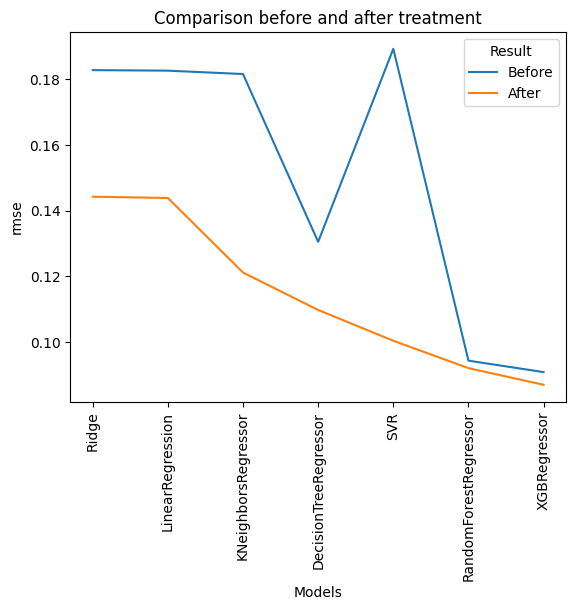

In [ ]:
# Se visualizan los resultados antes y después del tratamiento
models_list = ['Ridge', 'LinearRegression', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'SVR', 'RandomForestRegressor', 'XGBRegressor']
result = [['Before'], ['After']]

visualization_dict = {'Models': models_list * 2,
                      'rmse': [0.182826, 0.182664, 0.181632, 0.130480, 0.189328, 0.094246, 0.090762] + [0.144234, 0.143851, 0.121120, 0.109705, 0.100319, 0.091972, 0.086893],
                      'Result': result[0]*7 + result[1]*7
                      }

sns.lineplot(data=visualization_dict, x='Models', y='rmse', hue='Result')
plt.tick_params(axis='x', labelrotation=90)
plt.title(f'Comparison before and after treatment')
plt.show()
